<a href="https://colab.research.google.com/github/mauney/DS-Unit-2-Regression-Classification/blob/master/module3/assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [X] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [X] Do exploratory visualizations with Seaborn.
- [X] Do one-hot encoding of categorical features.
- [X] Do feature selection with `SelectKBest`.
- [X] Fit a linear regression model with multiple features.
- [X] Get mean absolute error for the test set.
- [X] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

## setup

In [0]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [4]:
# filter for one family dwellings that sold between $100,000 and $2,000,000
mask = (df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') & (df['SALE_PRICE'] > 100000) & (df['SALE_PRICE'] < 2000000)
df = df[mask]
print(df.shape)
df.head()

(3151, 21)


BOROUGH          NEIGHBORHOOD  ... SALE_PRICE   SALE_DATE
44         3   OCEAN PARKWAY-NORTH  ...     550000  01/01/2019
61         4        QUEENS VILLAGE  ...     200000  01/01/2019
78         2  PELHAM PARKWAY SOUTH  ...     810000  01/02/2019
108        3      FLATBUSH-CENTRAL  ...     125000  01/02/2019
111        3         FLATBUSH-EAST  ...     620000  01/02/2019

[5 rows x 21 columns]

## train/test split

In [5]:
# prep and inspect SALE_DATE
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'])
df['SALE_DATE'].describe()

count                    3151
unique                     91
top       2019-01-31 00:00:00
freq                       78
first     2019-01-01 00:00:00
last      2019-04-30 00:00:00
Name: SALE_DATE, dtype: object

In [6]:
# There are between 644 and 947 observations per month
df['SALE_DATE'].dt.month.value_counts()

1    947
3    799
2    761
4    644
Name: SALE_DATE, dtype: int64

In [7]:
# split into train and test sets
cutoff = pd.to_datetime('2019-04-01')
train = df[df['SALE_DATE'] < cutoff].copy()
test = df[df['SALE_DATE'] >= cutoff].copy()
train.shape, test.shape

((2507, 21), (644, 21))

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
train['BOROUGH'] = train['BOROUGH'].astype(str)
test['BOROUGH'] = test['BOROUGH'].astype(str)


# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

## profile the training data

In [0]:
import pandas_profiling

In [10]:
train.profile_report()

In [11]:
# the two building class columns are the same except for 3 values. We'll drop the '...at_present' column
changes = train['BUILDING_CLASS_AT_PRESENT'] != train['BUILDING_CLASS_AT_TIME_OF_SALE']
print(f'The number of observations that changed status: {changes.sum()}.')

# apartment_number is all NaN vaules expcept one
# tax class at present has 31 values 1D, but there is no class 1D. All other values are 1.
# the other three values have a constant value adn will also be dropped
drop_columns = ['APARTMENT_NUMBER', 'BUILDING_CLASS_AT_PRESENT',
                'BUILDING_CLASS_CATEGORY', 'EASE-MENT', 'TAX_CLASS_AT_PRESENT', 
                'TAX_CLASS_AT_TIME_OF_SALE']
train = train.drop(drop_columns, axis='columns')
test = test.drop(drop_columns, axis='columns')

# Land square feet should be numerical`
train['LAND_SQUARE_FEET'] = train['LAND_SQUARE_FEET'].str.replace(',', '').astype('int')
test['LAND_SQUARE_FEET'] = test['LAND_SQUARE_FEET'].str.replace(',', '').astype('int')

print(f'train shape: {train.shape}, test shape {test.shape}')

The number of observations that changed status: 3.
train shape: (2507, 15), test shape (644, 15)


## exploratory visualizations

In [12]:
train.head()

BOROUGH    NEIGHBORHOOD  ...  SALE_PRICE  SALE_DATE
44        3           OTHER  ...      550000 2019-01-01
61        4  QUEENS VILLAGE  ...      200000 2019-01-01
78        2           OTHER  ...      810000 2019-01-02
108       3           OTHER  ...      125000 2019-01-02
111       3           OTHER  ...      620000 2019-01-02

[5 rows x 15 columns]

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

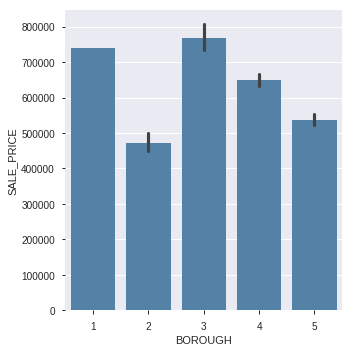

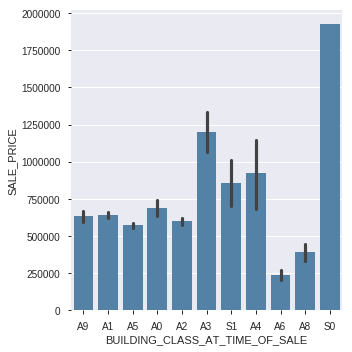

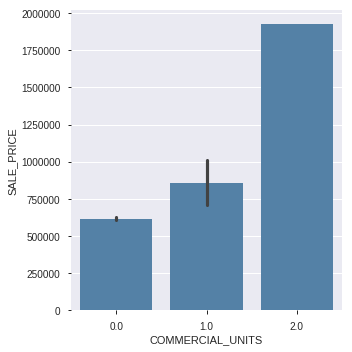

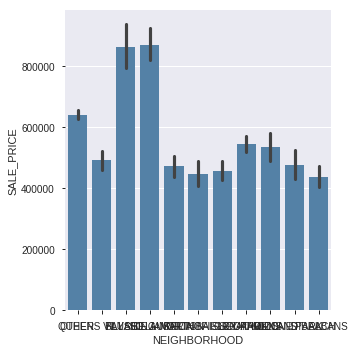

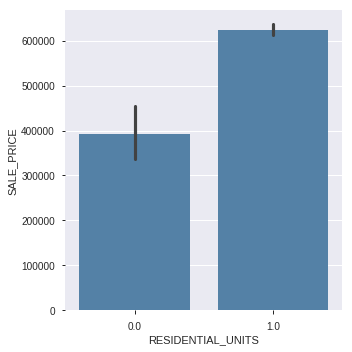

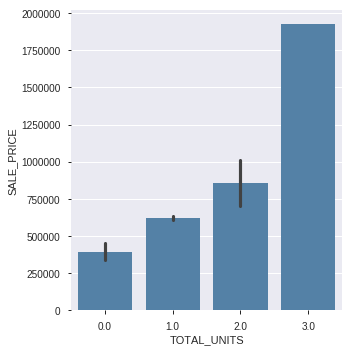

In [14]:
for col in sorted(train.columns):
  if train[col].nunique() < 13:
    sns.catplot(x=col, y='SALE_PRICE', data=train, kind='bar', color='steelblue')
    plt.show()

In [0]:
# One Hot encodes:
# borough
# buiilding class at time of sale
# neighborhood

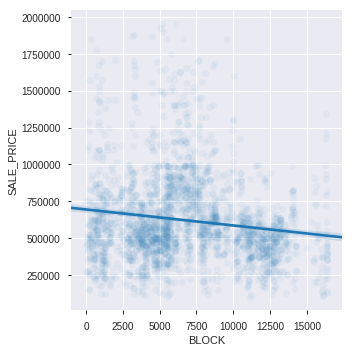

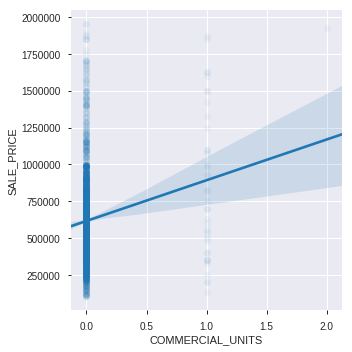

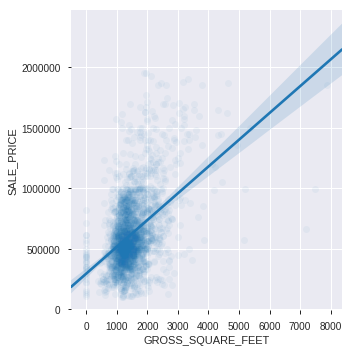

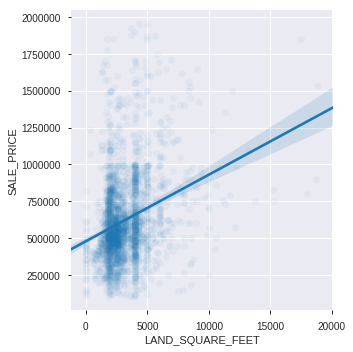

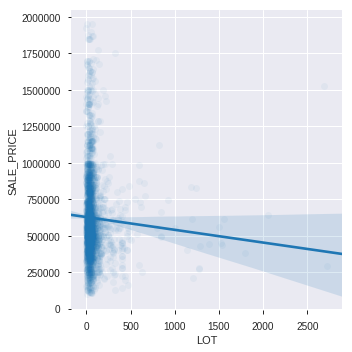

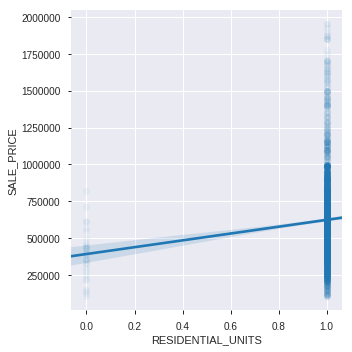

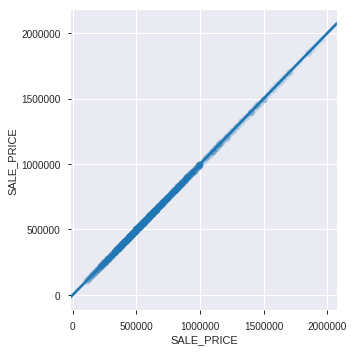

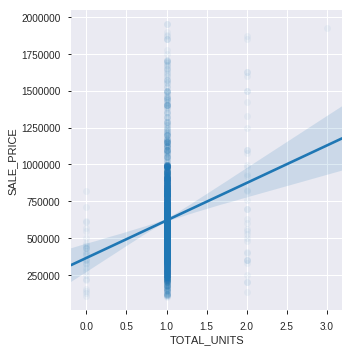

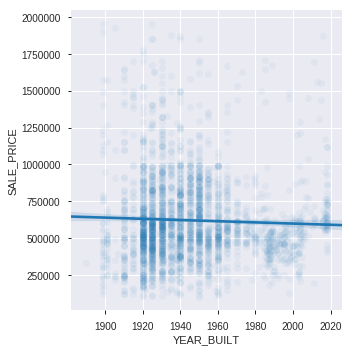

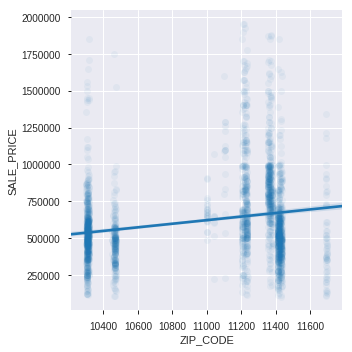

In [16]:
numeric = train.select_dtypes('number')
for col in sorted(numeric.columns):
  sns.lmplot(x=col, y='SALE_PRICE', data=train, scatter_kws=dict(alpha=0.05))
  plt.show()


In [0]:
# promising numerical columns: gross_square_feet, land_square_feet, total_units

## one-hot encoding 

In [18]:
# borough, neighborhood, and building_class will create 27 new columns
train.describe(exclude='number')

BOROUGH NEIGHBORHOOD  ... BUILDING_CLASS_AT_TIME_OF_SALE            SALE_DATE
count     2507         2507  ...                           2507                 2507
unique       5           11  ...                             11                   68
top          4        OTHER  ...                             A1  2019-01-31 00:00:00
freq      1204         1908  ...                            919                   78
first      NaN          NaN  ...                            NaN  2019-01-01 00:00:00
last       NaN          NaN  ...                            NaN  2019-03-30 00:00:00

[6 rows x 5 columns]

In [32]:
target = 'SALE_PRICE'
high_cardinality = ['ADDRESS', 'SALE_DATE']
features = train.columns.drop([target] + high_cardinality)

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

encoder = ce.OneHotEncoder( use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

for k in range(1, len(X_train_encoded.columns) + 1):
  print(f'{k} features')

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train_scaled, y_train)
  X_test_selected = selector.transform(X_test_scaled)

  model = LinearRegression()
  model.fit(X_train_selected, y_train)

  y_pred = model.predict(X_test_selected)
  mae = mean_absolute_error(y_test, y_pred)
  print(f'Test MAE: ${mae:,.0f} \n')



1 features
Test MAE: $183,641 

2 features
Test MAE: $179,555 

3 features
Test MAE: $179,291 

4 features
Test MAE: $178,897 

5 features
Test MAE: $177,128 

6 features
Test MAE: $177,168 

7 features
Test MAE: $171,968 

8 features
Test MAE: $168,817 

9 features
Test MAE: $168,273 

10 features
Test MAE: $157,234 

11 features
Test MAE: $158,181 

12 features
Test MAE: $157,041 

13 features
Test MAE: $157,057 

14 features
Test MAE: $156,750 

15 features
Test MAE: $158,856 

16 features
Test MAE: $158,726 

17 features
Test MAE: $158,609 

18 features
Test MAE: $158,372 

19 features
Test MAE: $158,851 

20 features
Test MAE: $158,882 

21 features
Test MAE: $158,913 

22 features
Test MAE: $159,531 

23 features
Test MAE: $41,138,173,788,449,976 

24 features
Test MAE: $54,488,962,633,341,008 

25 features
Test MAE: $43,481,712,218,729,464 

26 features
Test MAE: $5,359,573,802,168,520 

27 features
Test MAE: $18,431,610,078,672,204 

28 features
Test MAE: $20,057,248,258,265,00

In [34]:
# Not many gain after 10 features, so let's see the top ten
# Also, what happened between 22 and 23 features?
selector = SelectKBest(score_func=f_regression, k=10)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)

all_names = X_train_encoded.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]

print('Features selected:')
for name in selected_names:
  print(name)



Features selected:
BOROUGH_3
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_FLUSHING-NORTH
BLOCK
ZIP_CODE
TOTAL_UNITS
LAND_SQUARE_FEET
GROSS_SQUARE_FEET
BUILDING_CLASS_AT_TIME_OF_SALE_A3


In [33]:
X_train_encoded.head()

BOROUGH_3  ...  BUILDING_CLASS_AT_TIME_OF_SALE_S0
44           1  ...                                  0
61           0  ...                                  0
78           0  ...                                  0
108          1  ...                                  0
111          1  ...                                  0

[5 rows x 36 columns]